In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [5]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'U4TMRT2WQE0ATH2WCA1EDKOYQ1AVKFL2SPOKSELVY2DOTZA1' # your Foursquare ID
    CLIENT_SECRET = 'M1WKAGA1FO3DFXHKIKWDSKIQUJJNL0UZDBVWEODJ0YINB0EG' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [6]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'U4TMRT2WQE0ATH2WCA1EDKOYQ1AVKFL2SPOKSELVY2DOTZA1' # your Foursquare ID
    CLIENT_SECRET = 'M1WKAGA1FO3DFXHKIKWDSKIQUJJNL0UZDBVWEODJ0YINB0EG' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [7]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [8]:
new_york_data=get_new_york_data()

In [9]:

new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


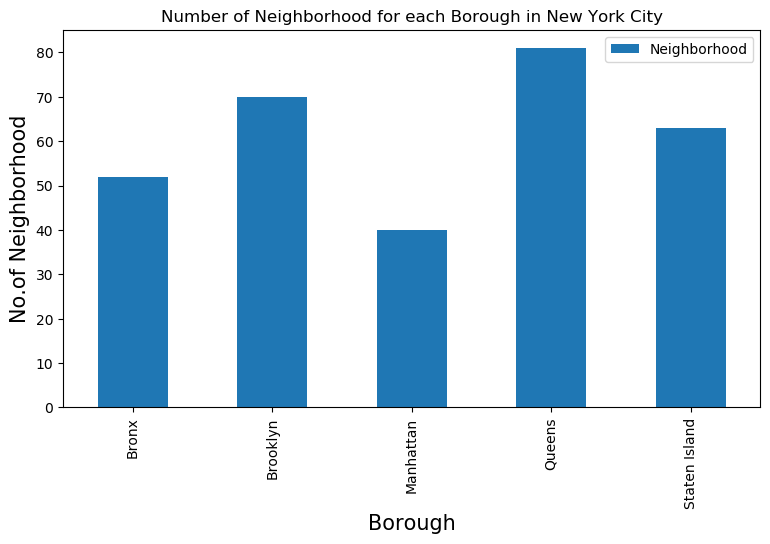

In [10]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [11]:
# prepare neighborhood list that contains French resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
french_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    french_resturants=venues[venues['Category']=='French Restaurant']   
    print('(',count,'/',len(new_york_data),')','French Resturants in '+Neighborhood+', '+Borough+':'+str(len(french_resturants)))
    for resturant_detail in french_resturants.values.tolist():
        id, name , category=resturant_detail
        french_rest_ny = french_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) French Resturants in Wakefield, Bronx:0
( 2 / 306 ) French Resturants in Co-op City, Bronx:0
( 3 / 306 ) French Resturants in Eastchester, Bronx:0
( 4 / 306 ) French Resturants in Fieldston, Bronx:0
( 5 / 306 ) French Resturants in Riverdale, Bronx:0
( 6 / 306 ) French Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) French Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) French Resturants in Woodlawn, Bronx:0
( 9 / 306 ) French Resturants in Norwood, Bronx:0
( 10 / 306 ) French Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) French Resturants in Baychester, Bronx:0
( 12 / 306 ) French Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) French Resturants in City Island, Bronx:1
( 14 / 306 ) French Resturants in Bedford Park, Bronx:0
( 15 / 306 ) French Resturants in University Heights, Bronx:0
( 16 / 306 ) French Resturants in Morris Heights, Bronx:0
( 17 / 306 ) French Resturants in Fordham, Bronx:0
( 18 / 306 ) French Resturants in East Tremont, Bronx:0
( 19 / 306 ) Fre

( 143 / 306 ) French Resturants in Maspeth, Queens:0
( 144 / 306 ) French Resturants in Ridgewood, Queens:0
( 145 / 306 ) French Resturants in Glendale, Queens:0
( 146 / 306 ) French Resturants in Rego Park, Queens:0
( 147 / 306 ) French Resturants in Woodhaven, Queens:0
( 148 / 306 ) French Resturants in Ozone Park, Queens:0
( 149 / 306 ) French Resturants in South Ozone Park, Queens:0
( 150 / 306 ) French Resturants in College Point, Queens:0
( 151 / 306 ) French Resturants in Whitestone, Queens:0
( 152 / 306 ) French Resturants in Bayside, Queens:0
( 153 / 306 ) French Resturants in Auburndale, Queens:0
( 154 / 306 ) French Resturants in Little Neck, Queens:1
( 155 / 306 ) French Resturants in Douglaston, Queens:1
( 156 / 306 ) French Resturants in Glen Oaks, Queens:0
( 157 / 306 ) French Resturants in Bellerose, Queens:0
( 158 / 306 ) French Resturants in Kew Gardens Hills, Queens:0
( 159 / 306 ) French Resturants in Fresh Meadows, Queens:0
( 160 / 306 ) French Resturants in Briarw

( 280 / 306 ) French Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) French Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) French Resturants in Weeksville, Brooklyn:1
( 283 / 306 ) French Resturants in Broadway Junction, Brooklyn:0
( 284 / 306 ) French Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) French Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) French Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) French Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) French Resturants in Egbertville, Staten Island:0
( 289 / 306 ) French Resturants in Roxbury, Queens:0
( 290 / 306 ) French Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) French Resturants in Middle Village, Queens:0
( 292 / 306 ) French Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) French Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) French Resturants in Richmond Valley, Staten Island:0
( 295 / 306 ) French Resturants in Malba, Queens:0
( 296 / 306 ) French Re

In [12]:
french_rest_ny.shape

(90, 4)

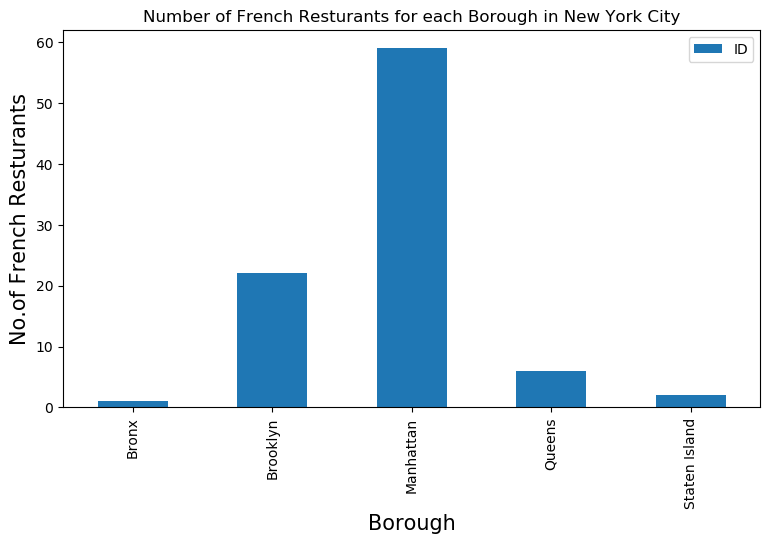

In [13]:
# we have 89 french restaurants across new york
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of French Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of French Resturants', fontsize=15)
#giving a bar plot
french_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [14]:

bronx_rest = french_rest_ny[french_rest_ny.Borough == 'Bronx']
# prepare  list that contains french resturants in Bronx
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
french_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in bronx_rest.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(bronx_rest),')','processed')
    french_rest_stats_ny = french_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID       Name  Likes  Rating  Tips
0  4d7aa83ee540f04d66ba16dc  Bistro SK     13     7.5     7
( 1 / 1 ) processed


In [15]:
french_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 7 columns):
Borough         1 non-null object
Neighborhood    1 non-null object
ID              1 non-null object
Name            1 non-null object
Likes           1 non-null object
Rating          1 non-null float64
Tips            1 non-null object
dtypes: float64(1), object(6)
memory usage: 72.0+ bytes


In [16]:
french_rest_stats_ny = pd.merge(french_rest_stats_ny,new_york_data,on = 'Neighborhood')

In [17]:
# all french restaurant rating and likes in the neigborhood
french_rest_stats_ny

,Borough_x,Neighborhood,ID,Name,Likes,Rating,Tips,Borough_y,Latitude,Longitude
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK,13,7.5,7,Bronx,40.847247,-73.786488


In [19]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

for lat, lng, in french_rest_stats_ny[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='Yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [21]:

# add pop-up text to each marker on the map
for lat, lng, label in french_rest_stats_ny[['Latitude','Longitude','Name']].values:
    folium.Marker([lat, lng], popup=Name).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [26]:
Bronx = new_york_data[new_york_data.Borough == 'Bronx']

In [35]:
print(Bronx.shape)
print(Bronx.head())

(52, 4)
  Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585
